# <center> VICAN: Tutorial</center>



In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon

from cam import estimate_pose_mp
from pgo import bipartite_se3sync, object_bipartite_se3sync
from plot import plot2D
from linalg import optimize_gauge_SE3, distance_SO3, angle
from dataset import Dataset

# Edit path to the folder containing the renders
RENDER_PATH = "./small_room_render"
# Edit path to the folder containing the cube calibration images.
OBJ_RENDER_PATH = "./cube_calib_render/"
# Edit marker size in meters (check render script to be sure)
MARKER_SIZE = 0.48*0.575
# Check which IDs are used 
MARKER_IDS = list(map(str, range(24)))

dataset     = Dataset(root=RENDER_PATH)
obj_dataset = Dataset(root=OBJ_RENDER_PATH)

# 1. Calibrate object: cube with 24 markers

In [2]:
aux = estimate_pose_mp(cams=obj_dataset.im_data['cam'],
                       im_filenames=obj_dataset.im_data['filename'],
                       aruco='DICT_4X4_1000',
                       marker_size=MARKER_SIZE,
                       corner_refine='CORNER_REFINE_APRILTAG',
                       marker_ids=MARKER_IDS,
                       flags='SOLVEPNP_IPPE_SQUARE',
                       brightness=-150,
                       contrast=120)

obj_pose_est = object_bipartite_se3sync(aux,
                                        noise_model_r=lambda edge : 0.01 * Polygon(zip(edge['corners'][:,0], edge['corners'][:,1])).area**2,
                                        noise_model_t=lambda edge : 0.001 * Polygon(zip(edge['corners'][:,0], edge['corners'][:,1])).area**6,
                                        edge_filter=lambda edge : edge['reprojected_err'] < 0.3,
                                        maxiter=4,
                                        lsqr_solver="conjugate_gradient",
                                        dtype=np.float64)

print("Error: {} deg".format(angle((obj_pose_est['1'] @ obj_pose_est['0'].inv()).R())))
print("Error: {} mm".format(np.round((np.linalg.norm((obj_pose_est['0'] @ obj_pose_est['2'].inv()).t(), ord=2) - 0.2875) * 1000, 3)))


Marker detection
Received 1440 images.
Started pool of 96 workers.
Merging dictionaries...
Found markers in 1440 images
Finished: 11385 markers detected.
Received graph with 1464 nodes 11385 edges
Applying constraints (0.561s).
Bipartite graph: 24 cameras, 1440 timesteps, 11122 edges.
Building 24x1440 adjacency and 72x4320 SO(3) sparse matrices (0.087s).
Building power graph (0.017s).


Optimizing:   0%|          | 0/4 [00:00<?, ?it/s]

Building sparse 33366x4392 incidence matrix (1.248s).
Solving sparse linear system (0.401s).
Done!
Error: 0.0 deg
Error: 1.194 mm


# 2. Detect markers & estimate camera-marker poses

In [3]:
"""
cam_marker_edges = estimate_pose_mp(cams=dataset.im_data['cam'],
                                    im_filenames=dataset.im_data['filename'],
                                    aruco='DICT_4X4_1000',
                                    marker_size=MARKER_SIZE,
                                    corner_refine='CORNER_REFINE_APRILTAG',
                                    marker_ids=MARKER_IDS,
                                    flags='SOLVEPNP_IPPE_SQUARE',
                                    brightness=-150,
                                    contrast=120)

torch.save(cam_marker_edges, os.path.join(RENDER_PATH, 'cam_marker_edges.pt'))
"""
cam_marker_edges = torch.load(os.path.join(RENDER_PATH, 'cam_marker_edges.pt'))

# 3. Pose graph optmization (VICAN)

In [4]:
# Select a subset of timesteps
edges = {k : v for k, v in cam_marker_edges.items() if int(k[1].split('_')[0]) < 5000}

pose_est = bipartite_se3sync(edges,
                             constraints=obj_pose_est,
                             noise_model_r=lambda edge : 0.01 * Polygon(zip(edge['corners'][:,0], edge['corners'][:,1])).area**2.0,
                             noise_model_t=lambda edge : 0.001 * Polygon(zip(edge['corners'][:,0], edge['corners'][:,1])).area**2.0,
                             edge_filter=lambda edge : edge['reprojected_err'] < 0.03,
                             maxiter=3,
                             lsqr_solver="conjugate_gradient",
                             dtype=np.float32)

Received graph with 38137 nodes 114499 edges
Applying constraints (1.224s).
Bipartite graph: 25 cameras, 4599 timesteps, 13858 edges.
Building 25x4599 adjacency and 75x13797 SO(3) sparse matrices (0.109s).
Building power graph (0.016s).


Optimizing:   0%|          | 0/3 [00:00<?, ?it/s]

Building sparse 58485x13872 incidence matrix (2.213s).
Solving sparse linear system (2.373s).
Done!


# 4. Comparison with ground-truth

In [5]:
missing_cam_ids = [c for c in dataset.cams.keys() if c not in pose_est.keys()]
valid_cam_ids   = [c for c in dataset.cams.keys() if c in pose_est.keys()]

G = optimize_gauge_SE3([dataset.cams[c].extrinsics.inv() for c in valid_cam_ids],
                       [pose_est[c] for c in valid_cam_ids])
r_err  = []
t_err  = []
for c in valid_cam_ids:
    gt  = dataset.cams[c].extrinsics.inv()
    est = pose_est[c] @ G
    t_err.append(np.linalg.norm(gt.t() - est.t(), ord=2)*100)
    r_err.append(distance_SO3(gt.R(), est.R()))              

print("SO(3)\t min: {:.3f}deg  |  avg: {:.3f}deg  |  median: {:.3f}deg  |  max: {:.3f}deg".format(np.min(r_err), np.mean(r_err), np.median(r_err), np.max(r_err)))
print("E(3) \t min: {:.3f}cm   |  avg: {:.3f}cm   |  median: {:.3f}cm   |  max: {:.3f}cm".format(np.min(t_err), np.mean(t_err), np.median(t_err), np.max(t_err)))
print("Missing cam IDs: {}".format(missing_cam_ids))

SO(3)	 min: 0.000deg  |  avg: 0.065deg  |  median: 0.079deg  |  max: 0.134deg
E(3) 	 min: 0.160cm   |  avg: 0.511cm   |  median: 0.557cm   |  max: 0.789cm
Missing cam IDs: []


# 5. 2D Plot

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


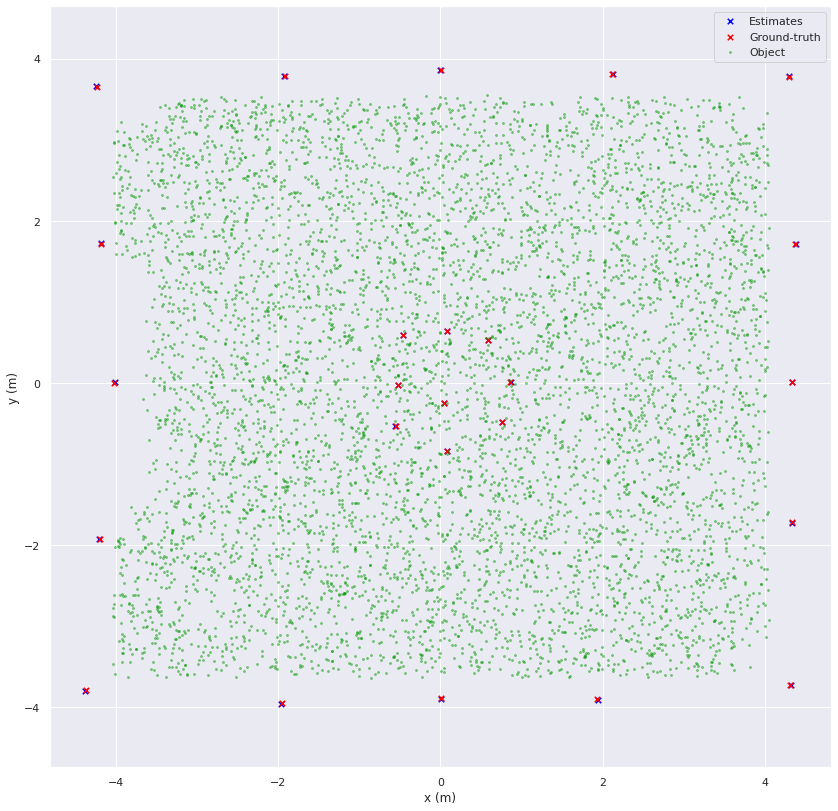

In [6]:
sns.set_theme()
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111)

plot2D(ax, pose_est, invert=True, idx=valid_cam_ids, gauge=G, view='xy', marker='x', s=30, c='blue')
plot2D(ax, dataset.cams, view='xy', marker='x', s=30, c='red')
plot2D(ax, dataset.object, view='xy', marker='.', s=15, c=[0,0.6,0,0.4])
plt.axis('equal')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.legend(['Estimates', 'Ground-truth', 'Object'])